In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from scipy.stats import ttest_ind, levene
import math as m
from yfinance import download
np.random.seed(0)

start = '2017-01-01'
end = '2019-12-31'

# define exception class for unequal stock histories
def histerror(a,b):
    class HistoryError(Exception):
        pass
    raise HistoryError('Stocks do not have equal history')
    
def checkhist(a,b):
    if len(a) != len(b):
        histerror(a,b)

In [2]:
def read_stock(stock):
    tab = download(stock, start=start, end=end)['Adj Close']
    tab.name = stock.upper()
    return tab

In [3]:
def returns(stock_table):
    returns = stock_table.copy()
    returns.iloc[1:] = returns.iloc[1:]/returns.values[:-1]
    returns.iloc[0] = 1
    return returns

In [4]:
# function to hold stock steadily
def hold(stock_table,money,inc,original_shares):
    
    # calculate daily returns
    ret = returns(stock_table)
    
    # dummy calculations to reset to full value of portfolio and initialize return calculations
    original_val = money + (stock_table.values[0]*original_shares)
    ret.iloc[0] = original_val
    
    # create actions table
    actions = pd.Series(['HOLD']*len(stock_table),index=stock_table.index)
    
    # create shares table
    shares = pd.Series([original_val/stock_table.values[0]]*len(stock_table),index=stock_table.index)
    
    # create cash table
    cash = pd.Series([0]*len(stock_table),index=stock_table.index)
    
    # calculate daily portfolio value
    final_vals = np.cumprod(ret)
    final_vals.columns = ['value']
    
    results = {'final_vals':final_vals,'actions':actions,'shares':shares,'cash':cash}
    return results

In [5]:
# function to randomly trade stock
def random_action(stock_table,money,inc,original_shares):

    # record original value
    original_val = money + (stock_table.values[0]*original_shares) # initial cash
    
    # generate table of returns
    ret = returns(stock_table)
    
    # create actions table
    actions = ['HOLD']
    
    # create shares table
    shares = stock_table.copy()
    shares.iloc[0] = original_shares

    # create cash table
    cash = stock_table.copy()
    cash.iloc[0] = money
    
    # calculate daily portfolio value
    final_vals = stock_table.copy()
    final_vals.iloc[0] = original_val
    
    # iterate through days
    for i in range(1,stock_table.shape[0]):
        j = i-1 # last day
        cur_cash = cash.values[j] # current cash
        cur_shares = shares.values[j] # current shares
        final_vals.iloc[i] = cur_cash + (cur_shares*stock_table.values[i]) # end of day portfolio value
        cur_price = stock_table.values[j]

        # if you can't buy or sell, hold
        if cur_shares < inc and cur_cash < (cur_price*inc):
            act = 'HOLD'
        
        # if you can't sell, but you can buy, buy or hold
        elif cur_shares < inc:
            act = np.random.choice(['BUY','HOLD']) 
            
        # if you can't buy, but you can sell, sell or hold
        elif cur_cash < (cur_price*inc):
            act = np.random.choice(['SELL','HOLD']) 
            
        # otherwise do whatever you want
        else:
            act = np.random.choice(['BUY','SELL','HOLD'])    
          
        # take action
        if act == 'HOLD':
            cash.iloc[i] = cash.values[j]
            shares.iloc[i] = shares.values[j]
        if act == 'BUY':
            cash.iloc[i] = cash.values[j] - (inc*cur_price)
            shares.iloc[i] = shares.values[j] + inc   
        if act == 'SELL':
            cash.iloc[i] = cash.values[j] + (inc*cur_price)
            shares.iloc[i] = shares.values[j] - inc
        
        actions += [act]
        
    actions = pd.Series(actions,index=stock_table.index)
    
    results = {'final_vals':final_vals,'actions':actions,'shares':shares,'cash':cash}
    return results


In [6]:
def rule_based(stock_table,money,inc, original_shares):

    # record original value
    original_val = money + (stock_table.values[0]*original_shares) # initial cash
    
    # generate table of returns
    ret = returns(stock_table)
    
    # create actions table
    actions = ['HOLD']
    
    # create shares table
    shares = stock_table.copy()
    shares.iloc[0] = original_shares
    
    # create cash table
    cash = stock_table.copy()
    cash.iloc[0] = money
    
    # calculate daily portfolio value
    final_vals = stock_table.copy()
    final_vals.iloc[0] = original_val
    
    # iterate through days
    for i in range(1,stock_table.shape[0]):
        j = i-1 # last day
        cur_cash = cash.values[j] # current cash
        cur_shares = shares.values[j] # current shares
        final_vals.iloc[i] = cur_cash + (cur_shares*stock_table.values[i]) # end of day portfolio value
        cur_price = stock_table.values[j]
        
        # calculate last return
        last_ret = ret.values[j]
        
        # if you can't buy or sell, hold
        if cur_shares < inc and cur_cash < (cur_price*inc):
            act = 'HOLD'
        
        # if you can't sell, but you can buy... buy if it makes sense, or hold if it doesn't
        elif cur_shares < inc:
            act = 'BUY' if last_ret > 1 else 'HOLD'
            
        # if you can't buy, but you can sell... sell if it makes sense, or hold if it doesn't
        elif cur_cash < (cur_price*inc):
            act = 'SELL' if last_ret < 1 else 'HOLD'
            
        # otherwise do whatever makes sense
        else:
            if last_ret > 1:
                act = 'BUY'
            elif last_ret < 1:
                act = 'SELL'
            else:
                act = 'HOLD'
          
        # take action
        if act == 'HOLD':
            cash.iloc[i] = cash.values[j]
            shares.iloc[i] = shares.values[j]
        if act == 'BUY':
            cash.iloc[i] = cash.values[j] - (inc*cur_price)
            shares.iloc[i] = shares.values[j] + inc   
        if act == 'SELL':
            cash.iloc[i] = cash.values[j] + (inc*cur_price)
            shares.iloc[i] = shares.values[j] - inc
        
        actions += [act]
        
    actions = pd.Series(actions,index=stock_table.index)
    
    results = {'final_vals':final_vals,'actions':actions,'shares':shares,'cash':cash}
    return results


In [7]:
def ols(stock_table,money,inc, original_shares):

    # set lookback window to one week
    lookback = 5

    # record original value
    original_val = money + (stock_table.values[0]*original_shares) # initial cash
    
    # generate table of returns
    ret = returns(stock_table)
    
    # create actions table
    actions = ['HOLD']
    
    # create shares table
    shares = stock_table.copy()
    shares.iloc[0] = original_shares
    
    # create cash table
    cash = stock_table.copy()
    cash.iloc[0] = money
    
    # calculate daily portfolio value
    final_vals = stock_table.copy()
    final_vals.iloc[0] = original_val
    
    # iterate through days
    for i in range(1,stock_table.shape[0]):
        j = i-1 # last day
        cur_cash = cash.values[j] # current cash
        cur_shares = shares.values[j] # current shares
        final_vals.iloc[i] = cur_cash + (cur_shares*stock_table.values[i]) # end of day portfolio value
        cur_price = stock_table.values[j]
        
        
        # Perform OLS if past day 3 to define expected return
        if i>2:
            st = ret.values[max(0,j-lookback):j+1] # y
            x = np.arange(len(st)) # x
            exp_ret = sm.OLS(st,add_constant(x)).fit().predict([1,len(st)])
        else:
            exp_ret = 1
   
    
        # if you can't buy or sell, hold
        if cur_shares < inc and cur_cash < (cur_price*inc):
            act = 'HOLD'
        
        # if you can't sell, but you can buy... buy if it makes sense, or hold if it doesn't
        elif cur_shares < inc:
            act = 'BUY' if exp_ret > 1 else 'HOLD'
            
        # if you can't buy, but you can sell... sell if it makes sense, or hold if it doesn't
        elif cur_cash < (cur_price*inc):
            act = 'SELL' if exp_ret < 1 else 'HOLD'
            
        # otherwise do whatever makes sense
        else:
            if exp_ret > 1:
                act = 'BUY'
            elif exp_ret < 1:
                act = 'SELL'
            else:
                act = 'HOLD'
          
        # take action
        if act == 'HOLD':
            cash.iloc[i] = cash.values[j]
            shares.iloc[i] = shares.values[j]
        if act == 'BUY':
            cash.iloc[i] = cash.values[j] - (inc*cur_price)
            shares.iloc[i] = shares.values[j] + inc   
        if act == 'SELL':
            cash.iloc[i] = cash.values[j] + (inc*cur_price)
            shares.iloc[i] = shares.values[j] - inc
        
        actions += [act]
        
    actions = pd.Series(actions,index=stock_table.index)
    
    results = {'final_vals':final_vals,'actions':actions,'shares':shares,'cash':cash}
    return results


In [8]:
def return_stats(stock='jpm',
                 money=100000,
                 #inc=10,- can readd this argument if doing absolute share-based
                 #original_shares=100, - can readd this argument if doing share-based
                 policies=[hold,random_action,rule_based,ols]):
    
    original_money = money
    
    # generate stock table
    stock_table = read_stock(stock)
    
    # note stock name
    stock_name = stock.upper()
    
    # approximate 50/50 split in money-stock
    original_shares = round(money / 2 / stock_table.values[0])
    
    # recalculate money accordingly
    money -= (stock_table.values[0]*original_shares)
    
    # make share increment about 1% of original share holdings
    inc = m.ceil(original_shares / 100)
    
    # generate results
    results = {policy.__name__:policy(stock_table,
                                      money = money,
                                      inc = inc,
                                      original_shares = original_shares) for policy in policies}
    
    # plot daily portfolio values
    plt.figure(figsize=(14,8))
    for policy in policies:
        plt.plot(results[policy.__name__]['final_vals'],label = policy.__name__)
    plt.legend()
    plt.xlabel("Date",fontsize=20)
    plt.ylabel("Portfolio Value ($)",fontsize=20)  
    plt.title("Daily Portfolio Values For Different Trading Strategies: "+stock.upper(),fontsize=25)
    plt.show()
    
    # plot daily cash values
    plt.figure(figsize=(14,8))
    for policy in policies:
        plt.plot(results[policy.__name__]['cash'],label = policy.__name__)
    plt.legend()
    plt.xlabel("Date",fontsize=20)
    plt.ylabel("Cash Held ($)",fontsize=20)  
    plt.title("Daily Cash Held For Different Trading Strategies: "+stock.upper(),fontsize=25)
    plt.show()
    
    # plot daily shares
    plt.figure(figsize=(14,8))
    for policy in policies:
        plt.plot(results[policy.__name__]['shares'],label = policy.__name__)
    plt.legend()
    plt.xlabel("Date",fontsize=20)
    plt.ylabel("Shares Held",fontsize=20)  
    plt.title("Daily Share Holdings For Different Trading Strategies: "+stock_name,fontsize=25)
    plt.show()
    
    # display value counts
    for policy in policies:
        print('For '+stock_name+',',policy.__name__)
        display(results[policy.__name__]['actions'].value_counts())
    print('\n')
    
    # calculate final returns
    for policy in policies:
        print('Final porfolio value under',policy.__name__,'strategy for '+stock_name+':',round(results[policy.__name__]['final_vals'].values[-1],0))
    print('\n')   
    
    # calculate final percentage of money invested in stock
    for policy in policies:
        print('Final percentage of money invested in stock under',policy.__name__,\
              'strategy for '+stock_name+':',str(round(100*(1-(results[policy.__name__]['cash'].values[-1]/results[policy.__name__]['final_vals'].values[-1])),1))+'%')
    print('\n') 
    
    # calculate returns
    rets = {policy:returns(results[policy.__name__]['final_vals']) for policy in policies}
    
    # generate risk_free return for sharpe ratio - five-year treasury yield
    rfs = returns(read_stock('^FVX'))
    
    # find common indecies between stock tables and treasury yields 
    rfn = set(stock_table.index).intersection(set(rfs.index))
    
    # now reindex 
    rfr = rfs.loc[rfn]
    rfi = rfr.index
    
    # generate baseline return for information ratio - s&p 500
    bls = returns(read_stock('^GSPC')).values
    
    # print summary stats for daily returns
    for policy in policies:
        nm = policy.__name__
        
        # mean daily return
        print('Mean daily return under',nm,'for',stock_name+':',str(round(np.mean(rets[policy],axis=0),4)))
        
        # standard deviation of daily return
        print('Standard deviation of daily return under',nm,'for',stock_name+':',round(np.std(rets[policy],axis=0),3))
        
        # information ratio of daily return
        checkhist(rets[policy].values,bls)
        pr = np.mean(rets[policy].values)
        br = np.mean(bls)
        te = np.std(rets[policy].values-bls)
        ir = round((pr-br)/(te),1)
        print('Information Ratio against S&P 500 under',nm,'strategy for',stock_name+':',ir)
        
        # sharpe ratio of daily return
        dat = rets[policy].loc[rfi].values # need to correct dates to line up with risk free return
        checkhist(dat,rfr)
        rp = np.mean(dat)
        br = np.mean(rfr)
        sd = np.std(rfr-dat)
        sr = round((rp-br)/(sd),1)
        print('Sharpe Ratio against five-year treasury yield under',nm,'strategy for',stock_name+':',sr)
        print('Note: only used dates when five-year treasury yields were available in calculating RFR for Sharpe Ratio')
        print('\n')
    
    for policy1 in policies:
        p1 = rets[policy1].loc[rfi].values # filter to dates with five-year treasury yields available
        n1 = policy1.__name__
        
        # independent samples t-test vs. risk-free return
        checkhist(p1,rfr)
        t = ttest_ind(p1,rfr,equal_var=True)
        gr = t[0] > 0
        n2 = 'rfr'
        p = round(t[1],3)/2 # make one-sided
        if gr:
            print('T-test for difference of mean returns in',n1,'and',n2,'finds',n1,'>',n2,'with p-value',round(p,3))
        else:
            print('T-test for difference of mean returns in',n2,'and',n1,'finds',n2,'>',n1,'with p-value',round(p,3))
            
        # welch's t-test vs. risk-free return
        t = ttest_ind(p1,rfr,equal_var=False)
        gr = t[0] > 0
        p = round(t[1],3)/2 # make one-sided
        if gr:
            print('Welch test for difference of mean returns in',n1,'and',n2,'finds',n1,'>',n2,'with p-value',round(p,3))
        else:
            print('Welch test for difference of mean returns in',n2,'and',n1,'finds',n2,'>',n1,'with p-value',round(p,3))

        # levene test vs. risk-free return
        l = levene(p1,rfr)
        p = round(l[1],3)
        gr = np.std(p1) > np.std(rfr)
        if gr:
            print('Levene test for difference of variances (volatility) in',n1,'and',n2,'finds p-value of',round(p,3),'with',n1,'showing more volatility')
        else:
            print('Levene test for difference of variances (volatility) in',n1,'and',n2,'finds p-value of',round(p,3),'with',n2,'showing more volatility')
        print('\n')
        
        for policy2 in policies:
            if policy1 != policy2: #and hash(policy1) <= hash(policy2) - not necessary
                p1 = rets[policy1].values # no longer need to filter to dates with five-year treasury yields available
                p2 = rets[policy2].values
                checkhist(p1,p2)
                n2 = policy2.__name__
                            
                # independent samples t-test
                t = ttest_ind(p1,p2,equal_var=True)
                gr = t[0] > 0
                p = round(t[1],3)/2 # make one-sided
                if gr:
                    print('T-test for difference of mean returns in',n1,'and',n2,'finds',n1,'>',n2,'with p-value',round(p,3))
                else:
                    print('T-test for difference of mean returns in',n2,'and',n1,'finds',n2,'>',n1,'with p-value',round(p,3))
                
                # welch's t-test
                t = ttest_ind(p1,p2,equal_var=False)
                gr = t[0] > 0
                p = round(t[1],3)/2 # make one-sided
                if gr:
                    print('Welch for difference of mean returns in',n1,'and',n2,'finds',n1,'>',n2,'with p-value',round(p,3))
                else:
                    print('Welch for difference of mean returns in',n2,'and',n1,'finds',n2,'>',n1,'with p-value',round(p,3))
                
                # levene test
                l = levene(p1,p2)
                p = round(l[1],3)
                gr = np.std(p1) > np.std(p2)
                if gr:
                    print('Levene test for difference of variances (volatility) in',n1,'and',n2,'finds p-value of',round(p,3),'with',n1,'showing more volatility')
                else:
                    print('Levene test for difference of variances (volatility) in',n1,'and',n2,'finds p-value of',round(p,3),'with',n2,'showing more volatility')
                print('\n')
            print('\n')

[*********************100%***********************]  1 of 1 completed


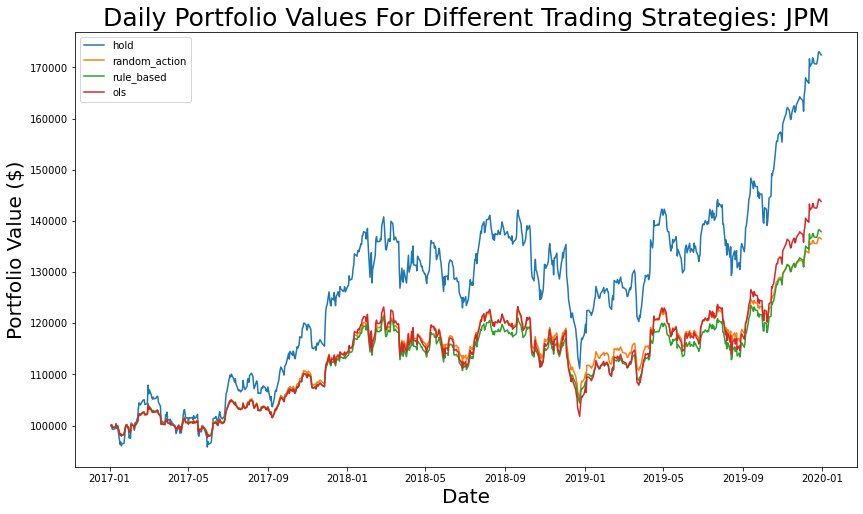

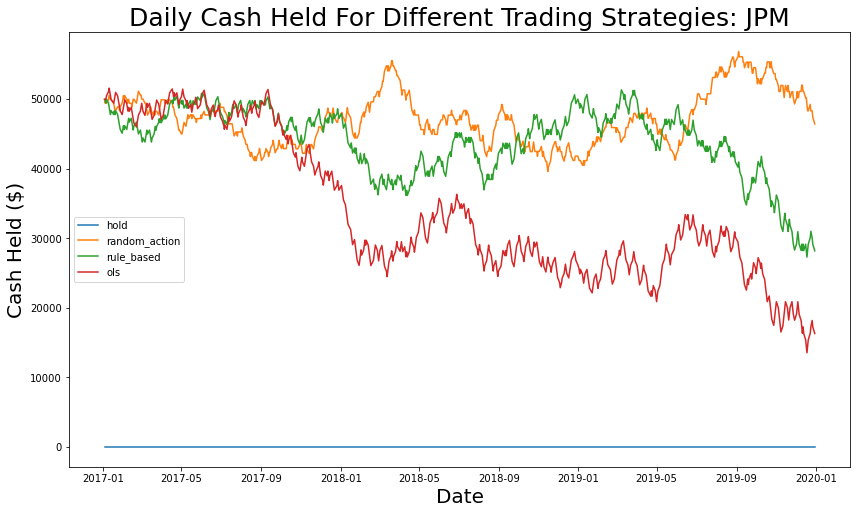

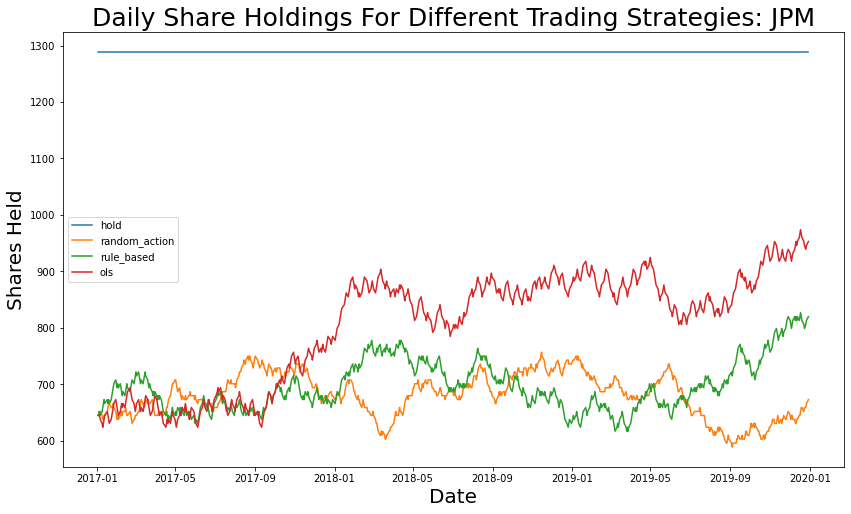

For JPM, hold


HOLD    753
dtype: int64

For JPM, random_action


BUY     257
SELL    253
HOLD    243
dtype: int64

For JPM, rule_based


BUY     386
SELL    361
HOLD      6
dtype: int64

For JPM, ols


BUY     397
SELL    353
HOLD      3
dtype: int64



Final porfolio value under hold strategy for JPM: 172454.0
Final porfolio value under random_action strategy for JPM: 136478.0
Final porfolio value under rule_based strategy for JPM: 137895.0
Final porfolio value under ols strategy for JPM: 143802.0


Final percentage of money invested in stock under hold strategy for JPM: 100.0%
Final percentage of money invested in stock under random_action strategy for JPM: 66.0%
Final percentage of money invested in stock under rule_based strategy for JPM: 79.6%
Final percentage of money invested in stock under ols strategy for JPM: 88.7%


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Mean daily return under hold for JPM: 1.0008
Standard deviation of daily return under hold for JPM: 0.012
Information Ratio against S&P 500 under hold strategy for JPM: 0.0
Sharpe Ratio against five-year treasury yield under hold strategy for JPM: 0.0
Note: only used dates w

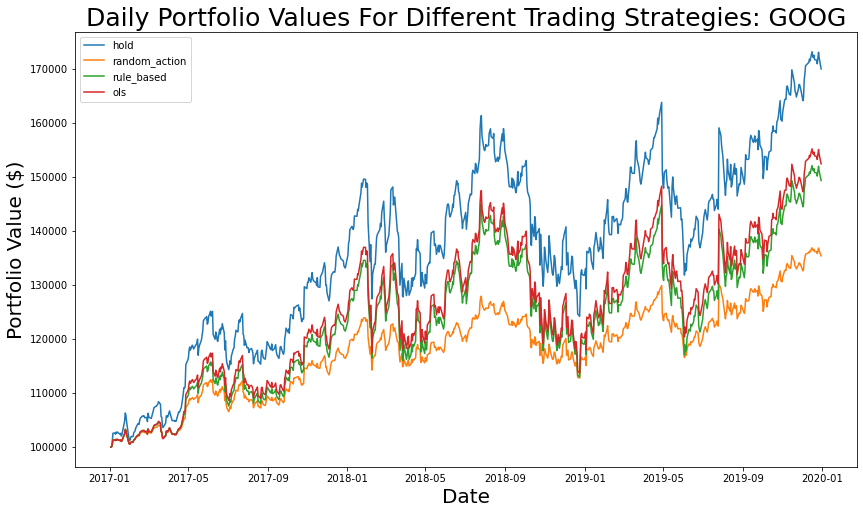

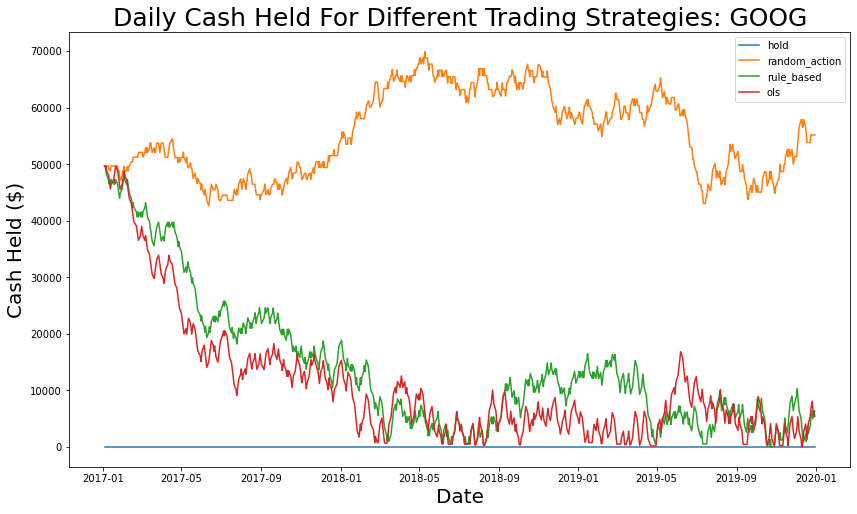

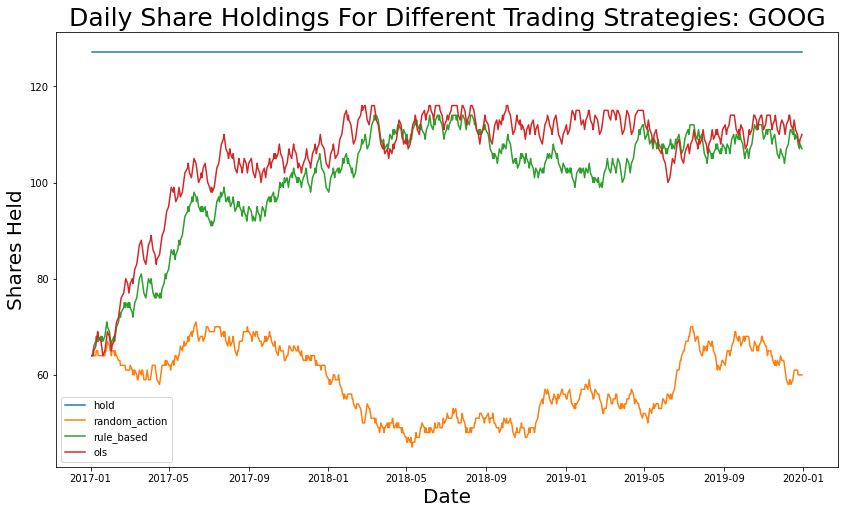

For GOOG, hold


HOLD    753
dtype: int64

For GOOG, random_action


SELL    258
BUY     254
HOLD    241
dtype: int64

For GOOG, rule_based


BUY     388
SELL    345
HOLD     20
dtype: int64

For GOOG, ols


BUY     375
SELL    329
HOLD     49
dtype: int64



Final porfolio value under hold strategy for GOOG: 169962.0
Final porfolio value under random_action strategy for GOOG: 135364.0
Final porfolio value under rule_based strategy for GOOG: 149316.0
Final porfolio value under ols strategy for GOOG: 152388.0


Final percentage of money invested in stock under hold strategy for GOOG: 100.0%
Final percentage of money invested in stock under random_action strategy for GOOG: 59.2%
Final percentage of money invested in stock under rule_based strategy for GOOG: 95.7%
Final percentage of money invested in stock under ols strategy for GOOG: 96.5%


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Mean daily return under hold for GOOG: 1.0008
Standard deviation of daily return under hold for GOOG: 0.015
Information Ratio against S&P 500 under hold strategy for GOOG: 0.0
Sharpe Ratio against five-year treasury yield under hold strategy for GOOG: 0.0
Note: only 

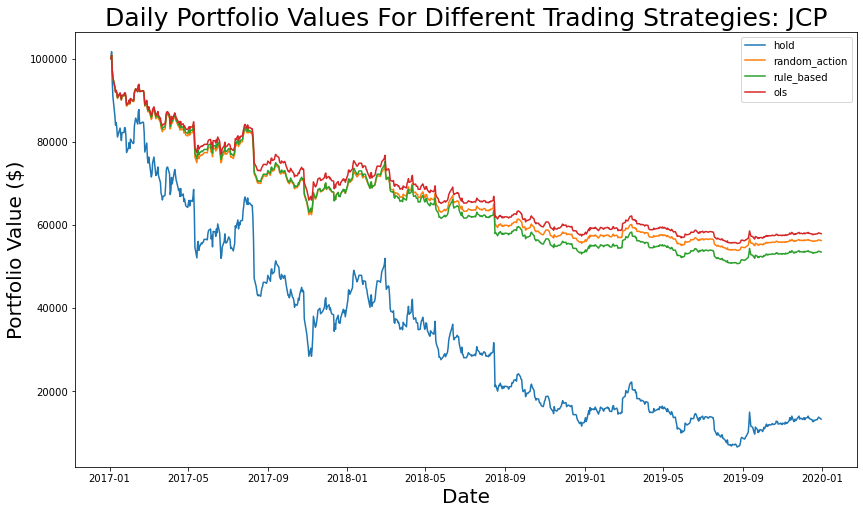

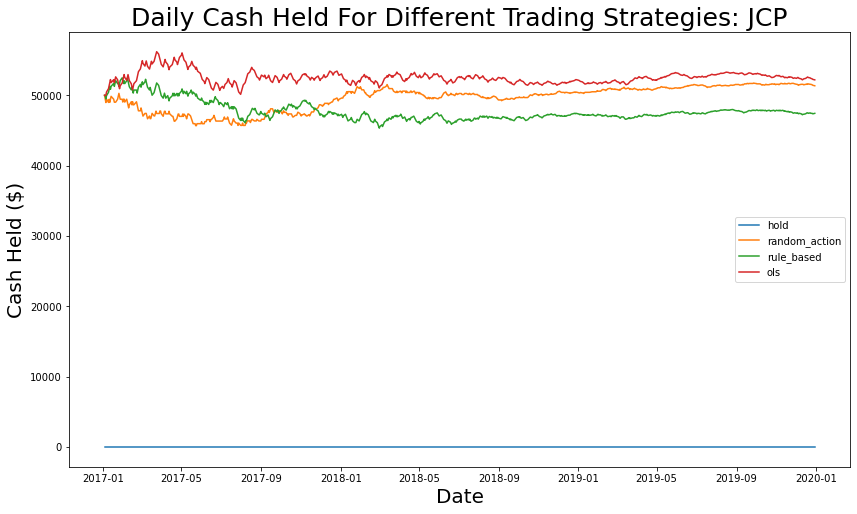

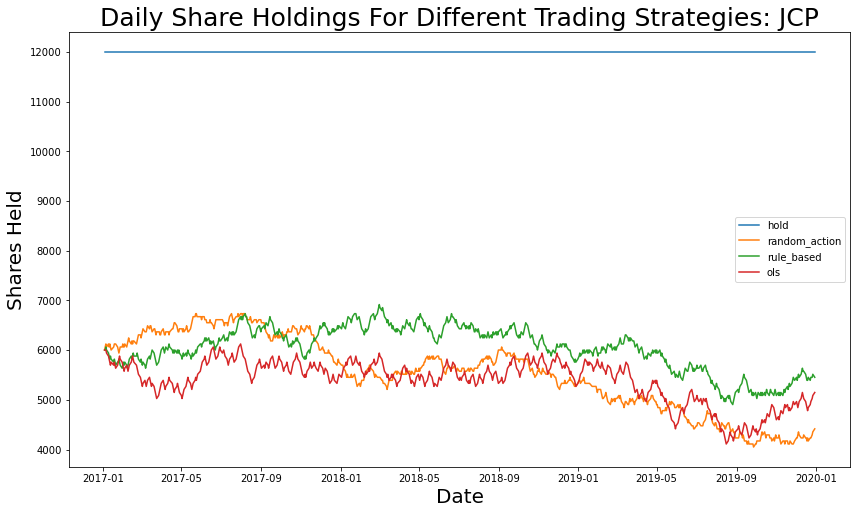

For JCP, hold


HOLD    753
dtype: int64

For JCP, random_action


SELL    262
HOLD    255
BUY     236
dtype: int64

For JCP, rule_based


SELL    360
BUY     351
HOLD     42
dtype: int64

For JCP, ols


SELL    382
BUY     368
HOLD      3
dtype: int64



Final porfolio value under hold strategy for JCP: 13325.0
Final porfolio value under random_action strategy for JCP: 56266.0
Final porfolio value under rule_based strategy for JCP: 53494.0
Final porfolio value under ols strategy for JCP: 57919.0


Final percentage of money invested in stock under hold strategy for JCP: 100.0%
Final percentage of money invested in stock under random_action strategy for JCP: 8.7%
Final percentage of money invested in stock under rule_based strategy for JCP: 11.3%
Final percentage of money invested in stock under ols strategy for JCP: 9.9%


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Mean daily return under hold for JCP: 0.9983
Standard deviation of daily return under hold for JCP: 0.044
Information Ratio against S&P 500 under hold strategy for JCP: -0.1
Sharpe Ratio against five-year treasury yield under hold strategy for JCP: -0.0
Note: only used dates when 

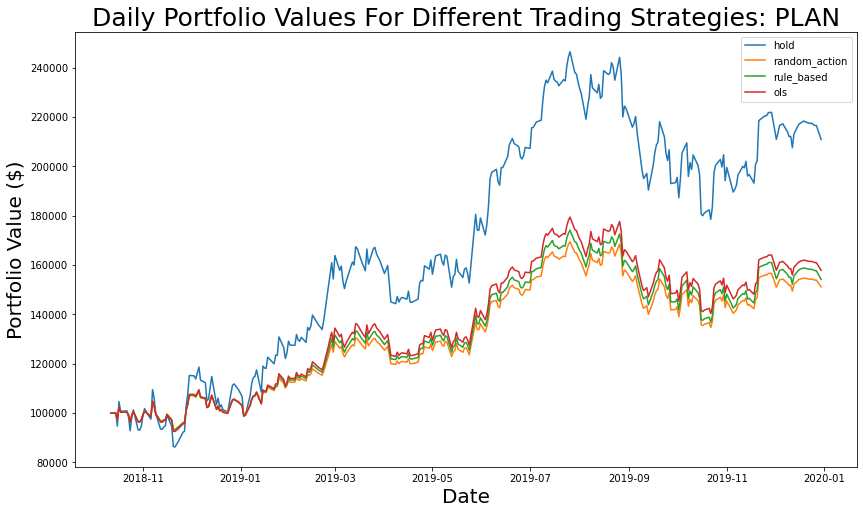

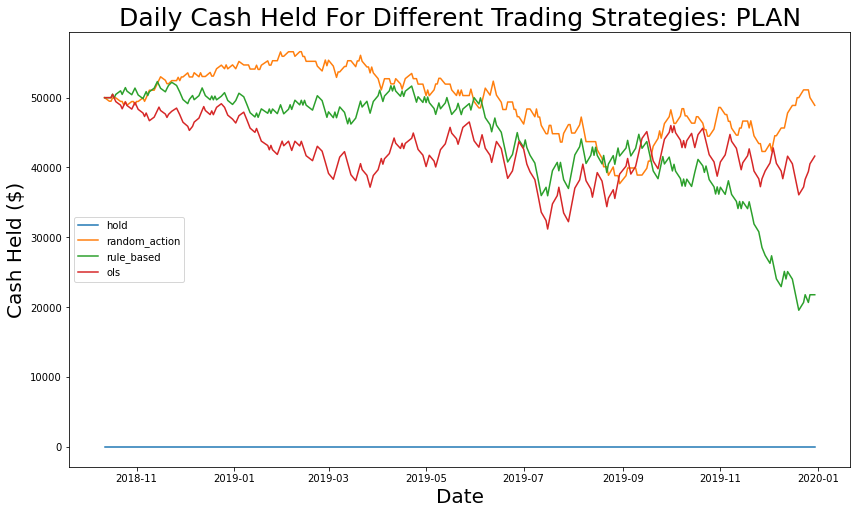

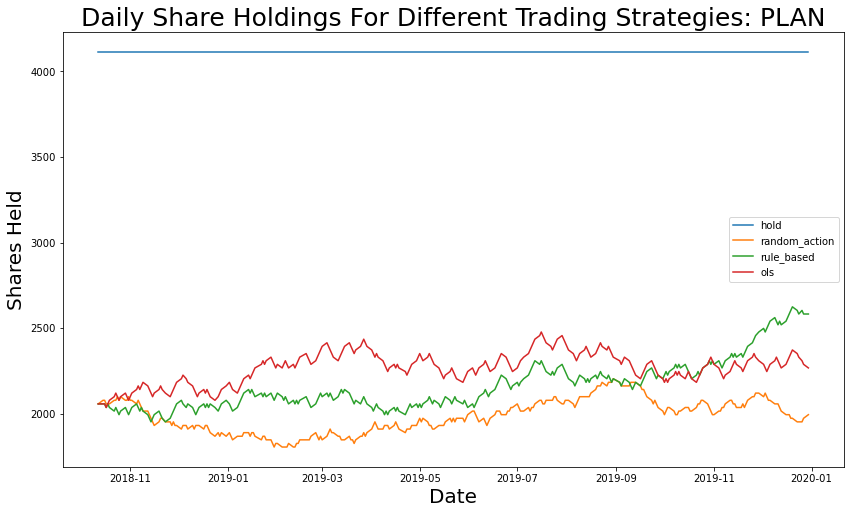

For PLAN, hold


HOLD    305
dtype: int64

For PLAN, random_action


HOLD    104
SELL    102
BUY      99
dtype: int64

For PLAN, rule_based


BUY     163
SELL    138
HOLD      4
dtype: int64

For PLAN, ols


BUY     156
SELL    146
HOLD      3
dtype: int64



Final porfolio value under hold strategy for PLAN: 210905.0
Final porfolio value under random_action strategy for PLAN: 151167.0
Final porfolio value under rule_based strategy for PLAN: 154170.0
Final porfolio value under ols strategy for PLAN: 157835.0


Final percentage of money invested in stock under hold strategy for PLAN: 100.0%
Final percentage of money invested in stock under random_action strategy for PLAN: 67.7%
Final percentage of money invested in stock under rule_based strategy for PLAN: 85.9%
Final percentage of money invested in stock under ols strategy for PLAN: 73.6%


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Mean daily return under hold for PLAN: 1.003
Standard deviation of daily return under hold for PLAN: 0.035


HistoryError: Stocks do not have equal history

In [9]:
stocks = ['jpm','goog','jcp','plan','chgg']
for stock in stocks:
    return_stats(stock)